# Supervised Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import keras
import keras_metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout

import talos

from functions import *

## Quick Data Cleaning


### NBA Shot Logs

* Encoding `LOCATION`: Away = 0, Home = 1
* Encoding `SHOT_RESULT`: missed = 0, made = 1
* Converting `GAME_CLOCK` to seconds
* Dropping rows where `SHOT_CLOCK` == 0
* `CLOSEST_DEFENDER` and `player_name` to dummy variables

In [2]:
df = pd.read_csv('shot_logs.csv').drop(['MATCHUP', 'W', 'FINAL_MARGIN', 'FGM', 'PTS', 
                                       'player_id', 'CLOSEST_DEFENDER_PLAYER_ID', 'GAME_ID',
                                       'PTS_TYPE'], axis=1)
df = df.dropna()
df.LOCATION = df.LOCATION.replace({'A': 0, 'H': 1})
df.SHOT_RESULT = df.SHOT_RESULT.replace({'missed': 0, 'made': 1})
df['PERIOD_SECONDS'] = (pd.to_datetime(df.GAME_CLOCK, format='%M:%S') - pd.to_datetime('1900-01-01')).dt.total_seconds()
nba = pd.concat([df.drop(['CLOSEST_DEFENDER', 'player_name', 'GAME_CLOCK'], axis=1), pd.get_dummies(df[['CLOSEST_DEFENDER', 'player_name']])], axis=1)


In [30]:
nba.SHOT_RESULT.value_counts(normalize=True)

0    0.543844
1    0.456156
Name: SHOT_RESULT, dtype: float64

### Credit Card Fraud

- Dropped `Time` column

In [3]:
cc = pd.read_csv('creditcard.csv').drop('Time', axis=1)

In [22]:
cc.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

## Model Prep

In [2]:
nba = pd.read_csv('nba_cleaned.csv')
cc = pd.read_csv('cc_cleaned.csv')

In [3]:
X1, y1 = nba.drop('SHOT_RESULT', axis=1), nba['SHOT_RESULT']
X2, y2 = cc.drop('Class', axis=1), cc['Class']

## Decision Tree

### Initial GridSearch

In [134]:
dtree_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [10, 20, 30], 
              'min_samples_split': [5, 10, 15], 
              'max_features': [None, "sqrt", "log2"]}

dtree_tuned1 = GridSearchCV(DecisionTreeClassifier(), dtree_grid, 
                          scoring='accuracy', cv=5, verbose=1)

dtree_tuned2 = GridSearchCV(DecisionTreeClassifier(), dtree_grid, 
                          scoring='recall', cv=5, verbose=1)

In [135]:
gridsearches(dtree_tuned1, dtree_tuned2, X1, y1, X2, y2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Params 1:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_split': 15}
Best Params 2:  {'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_split': 5}


(GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [10, 20, 30],
                          'max_features': [None, 'sqrt', 'log2'],
                          'min_samples_split': [5, 10, 15]},
              scoring='accuracy', verbose=1),
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [10, 20, 30],
                          'max_features': [None, 'sqrt', 'log2'],
                          'min_samples_split': [5, 10, 15]},
              scoring='recall', verbose=1))

In [160]:
pd.DataFrame(dtree_tuned1.cv_results_).set_index('rank_test_score')[['params', 'mean_test_score']].sort_index().to_csv('dtree_grid1.csv')
pd.DataFrame(dtree_tuned2.cv_results_).set_index('rank_test_score')[['params', 'mean_test_score']].sort_index().to_csv('dtree_grid2.csv')


### Tree Depth

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=21)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=21)

In [158]:
test = DecisionTreeClassifier()
test.fit(X_train, y_train)
test.get_depth()

144

In [159]:
test2 = DecisionTreeClassifier()
test2.fit(X_train2, y_train2)
test2.get_depth()

24

Maximum tree depths are: 144 for NBA and 24 for Fraud

In [164]:
train_accuracy1 = []
test_accuracy1 = []
train_times1 = []

for i in [5, 10, 20, 30, 40, 50, 75, 100, 125, 150]:
    m = DecisionTreeClassifier(criterion='entropy', min_samples_split=15, max_features=None, max_depth=i)
    
    train_start1 = time.time()
    m.fit(X_train, y_train)
    train_time1 = time.time() - train_start1
    train_times1.append(train_time1)
    
    train_preds = m.predict(X_train)
    test_preds = m.predict(X_test)
    train_accuracy1.append(accuracy_score(y_train, train_preds))
    test_accuracy1.append(accuracy_score(y_test, test_preds))
    

In [179]:
train_accuracy2 = []
test_accuracy2 = []
train_recall2 = []
test_recall2 = []
train_times2 = []

for i in [2, 4, 6, 8, 10, 12, 16, 20, 25, 30]:
    m = DecisionTreeClassifier(criterion='gini', min_samples_split=5, max_features=None, max_depth=i)
    
    train_start2 = time.time()
    m.fit(X_train, y_train)
    train_time2 = time.time() - train_start2
    train_times2.append(train_time2)
    
    train_preds = m.predict(X_train)
    test_preds = m.predict(X_test)
    train_accuracy2.append(accuracy_score(y_train, train_preds))
    test_accuracy2.append(accuracy_score(y_test, test_preds))
    train_recall2.append(recall_score(y_train, train_preds))
    test_recall2.append(recall_score(y_test, test_preds))
    

In [181]:
results_dtree_depth = pd.DataFrame()
results_dtree_depth['Depths 1'] = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150]
results_dtree_depth['Depths 2'] = [2, 4, 6, 8, 10, 12, 16, 20, 25, 30]
results_dtree_depth['Train Accuracy 1'] = train_accuracy1
results_dtree_depth['Test Accuracy 1'] = test_accuracy1
results_dtree_depth['Train Time 1'] = train_times1

results_dtree_depth['Train Accuracy 2'] = train_accuracy2
results_dtree_depth['Test Accuracy 2'] = test_accuracy2
results_dtree_depth['Train Recall 2'] = train_recall2
results_dtree_depth['Test Recall 2'] = test_recall2
results_dtree_depth['Train Time 2'] = train_times2

In [182]:
results_dtree_depth

,Depths 1,Depths 2,Train Accuracy 1,Test Accuracy 1,Train Time 1,Train Accuracy 2,Test Accuracy 2,Train Recall 2,Test Recall 2,Train Time 2
0,5,2,0.617432,0.611322,2.433885,0.607882,0.604179,0.365638,0.366009,1.006215
1,10,4,0.629565,0.611649,4.959715,0.615932,0.610832,0.297116,0.296323,1.792686
2,20,6,0.664932,0.600751,9.845135,0.620596,0.612179,0.355243,0.346906,2.877598
3,30,8,0.707789,0.590874,13.930734,0.626759,0.613485,0.347194,0.337130,3.969744
4,40,10,0.741574,0.585486,17.030363,0.634810,0.611159,0.342947,0.322960,5.106048
5,50,12,0.773176,0.577038,19.320919,0.644851,0.609200,0.357501,0.323408,6.156588
6,75,16,0.831481,0.559447,22.530880,0.668667,0.602343,0.418466,0.349148,8.151248
7,100,20,0.858920,0.553733,24.276983,0.698187,0.598792,0.468455,0.363408,10.162255
8,125,25,0.874369,0.549855,24.496921,0.743094,0.594098,0.531522,0.369596,12.063476
9,150,30,0.877940,0.549651,24.362437,0.782665,0.584507,0.590074,0.374439,13.228670


In [183]:
def plot_depth_metrics(results, model_name):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
    ax0.plot(results['Depths 1'], results['Train Accuracy 1'], label = 'Training Accuracy')
    ax0.plot(results['Depths 1'], results['Test Accuracy 1'], label = 'Testing Accuracy')
    ax0.set_title('Learning Curve: NBA Shots')
    ax0.set_xlabel('Tree Depth')
    ax0.set_ylabel('Accuracy Score')
    
    ax0.legend()

    ax1.plot(results['Depths 2'], results['Train Accuracy 2'], label = 'Training Accuracy')
    ax1.plot(results['Depths 2'], results['Test Accuracy 2'], label = 'Testing Accuracy')

    ax1.plot(results['Depths 2'], results['Train Recall 2'], label = 'Training Recall')
    ax1.plot(results['Depths 2'], results['Test Recall 2'], label = 'Testing Recall')

    ax1.set_title('Learning Curve: Fraud')
    ax1.set_xlabel('Tree Depth')
    ax1.set_ylabel('Accuracy/Recall Score')
    ax1.legend()
    
    ax2.plot(results['Depths 1'], results['Train Time 1'], label = 'Training Time', color = 'lime')
    ax2.set_title('Model Fit Time: NBA Shots')
    ax2.set_xlabel('Tree Depth')
    ax2.set_ylabel('Time (Seconds)')
    ax2.legend()

    ax3.plot(results['Depths 2'], results['Train Time 2'], label = 'Training Time', color = 'aqua')
    ax3.set_title('Model Fit Time: Fraud')
    ax3.set_xlabel('Tree Depth')
    ax3.set_ylabel('Time (Seconds)')
    ax3.legend()
    
    
    fig.suptitle(f'Tree Depths and Fit Times: {model_name}', fontsize='x-large', y=0.93)

    plt.show()

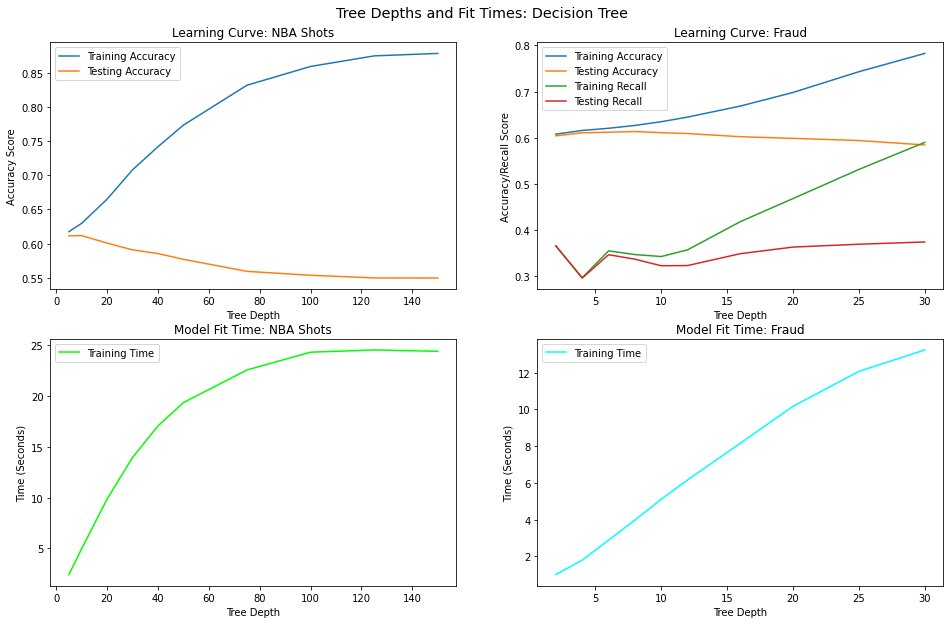

In [184]:
plot_depth_metrics(results_dtree_depth, 'Decision Tree')

### Learning Curves

In [186]:
dtree_results = sample_model(DecisionTreeClassifier(criterion='entropy', min_samples_split=15, max_depth=10), 
                             DecisionTreeClassifier(criterion='gini', min_samples_split=5, max_depth=30), 
                             nba, cc)

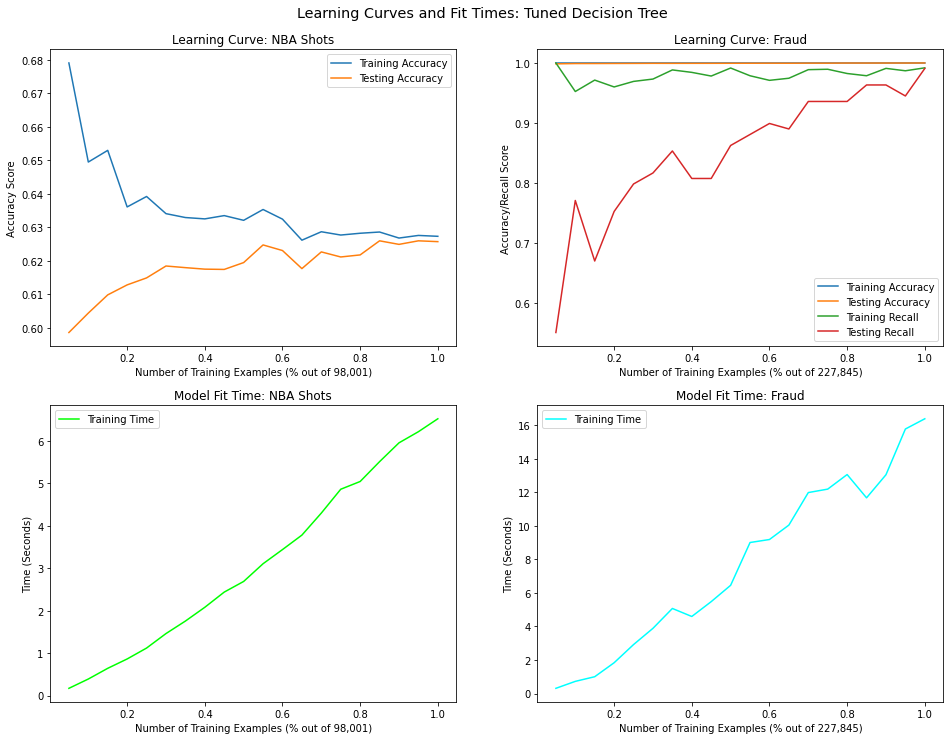

In [189]:
plot_metrics(dtree_results, 'Tuned Decision Tree')

## Adaboost

### Initial GridSearch

In [190]:
ada_grid = {'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150, 200, 250], 
            'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]}

ada_tuned1 = GridSearchCV(AdaBoostClassifier(), ada_grid, scoring='accuracy', cv=5, verbose=1)
ada_tuned2 = GridSearchCV(AdaBoostClassifier(), ada_grid, scoring='recall', cv=5, verbose=1)

In [191]:
gridsearches(ada_tuned1, ada_tuned2, X1, y1, X2, y2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params 1:  {'learning_rate': 0.5, 'n_estimators': 250}
Best Params 2:  {'learning_rate': 1.5, 'n_estimators': 250}


(GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
              param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1,
                                            1.25, 1.5, 2],
                          'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150, 200,
                                           250]},
              scoring='accuracy', verbose=1),
 GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
              param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1,
                                            1.25, 1.5, 2],
                          'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150, 200,
                                           250]},
              scoring='recall', verbose=1))

In [195]:
pd.DataFrame(ada_tuned2.cv_results_).to_csv('ada_tuned2.csv')

In [48]:
ada_results_1 = pd.read_csv('model_results/ada_tuned1.csv')[['mean_fit_time', 'mean_score_time',
                                              'param_learning_rate', 'param_n_estimators', 
                                              'mean_test_score', 'rank_test_score']]
ada_results_2 = pd.read_csv('model_results/ada_tuned2.csv')[['mean_fit_time', 'mean_score_time',
                                              'param_learning_rate', 'param_n_estimators', 
                                              'mean_test_score', 'rank_test_score']]

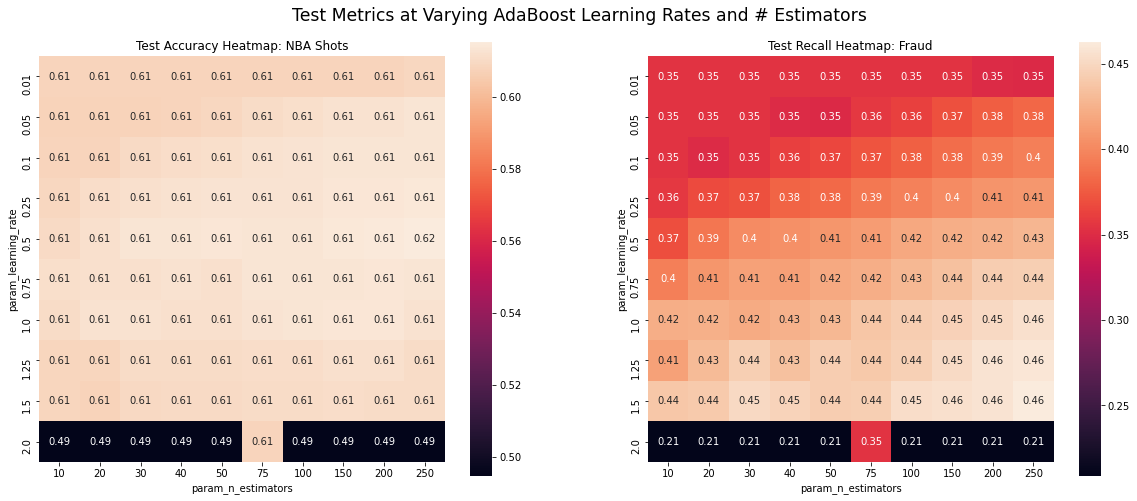

In [65]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(ada_results_1.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_test_score'), square=True, annot=True, ax=ax0);

sns.heatmap(ada_results_2.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_test_score'), square=True, annot=True, ax=ax1);

ax0.set_title('Test Accuracy Heatmap: NBA Shots')
ax1.set_title('Test Recall Heatmap: Fraud')
plt.suptitle('Test Metrics at Varying AdaBoost Learning Rates and # Estimators', fontsize='xx-large', y=0.94)
plt.show()

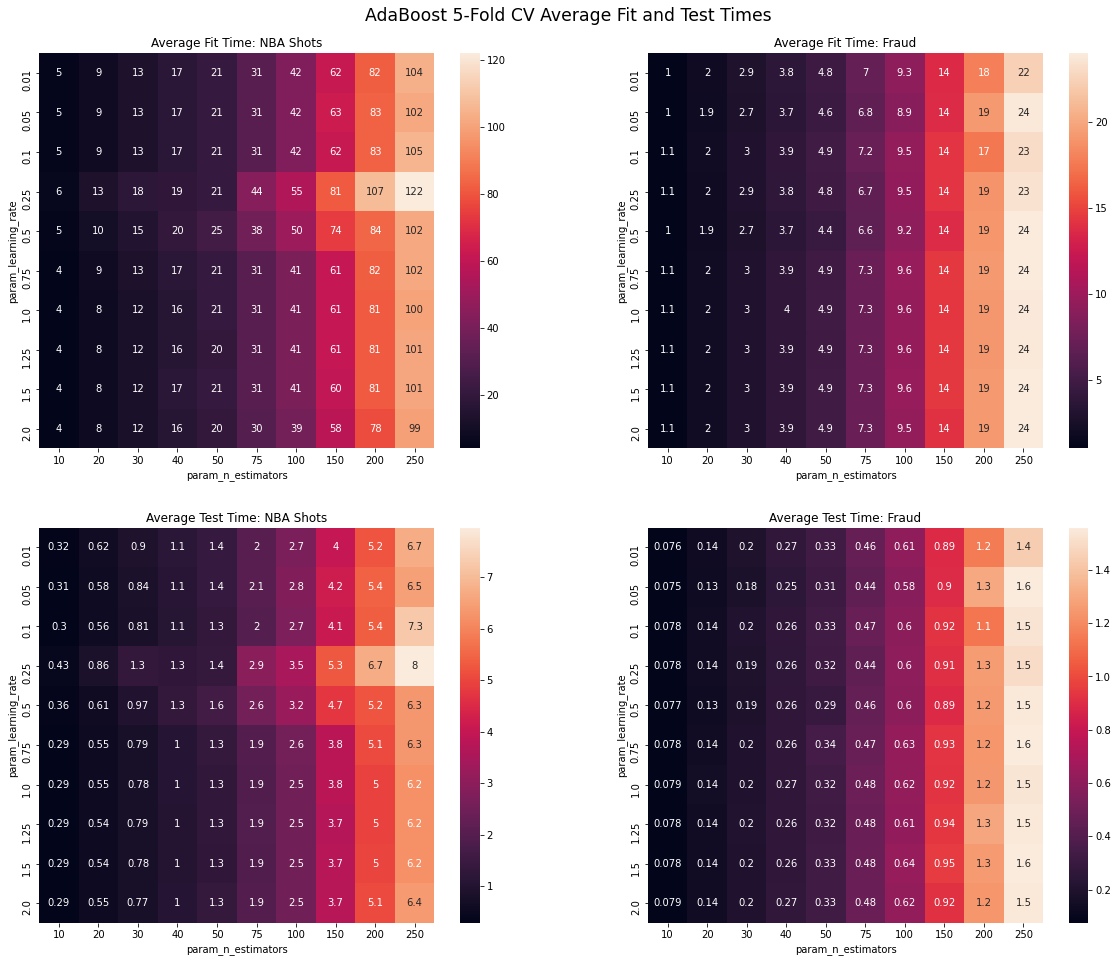

In [62]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 16))

sns.heatmap(round(ada_results_1.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_fit_time')), square=True, annot=True, ax=ax0, fmt='.3g');

sns.heatmap(ada_results_2.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_fit_time'), square=True, annot=True, ax=ax1);

sns.heatmap(ada_results_1.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_score_time'), square=True, annot=True, ax=ax2);

sns.heatmap(ada_results_2.pivot(index='param_learning_rate', columns='param_n_estimators', 
                   values='mean_score_time'), square=True, annot=True, ax=ax3);

ax0.set_title('Average Fit Time: NBA Shots')
ax1.set_title('Average Fit Time: Fraud')
ax2.set_title('Average Test Time: NBA Shots')
ax3.set_title('Average Test Time: Fraud')

plt.suptitle('AdaBoost 5-Fold CV Average Fit and Test Times', fontsize='xx-large', y=0.92)
plt.show()

### Learning Curve

In [196]:
ada_results = sample_model(AdaBoostClassifier(n_estimators=250, learning_rate=0.5), 
                           AdaBoostClassifier(n_estimators=250, learning_rate=1.5), 
                           nba, cc)

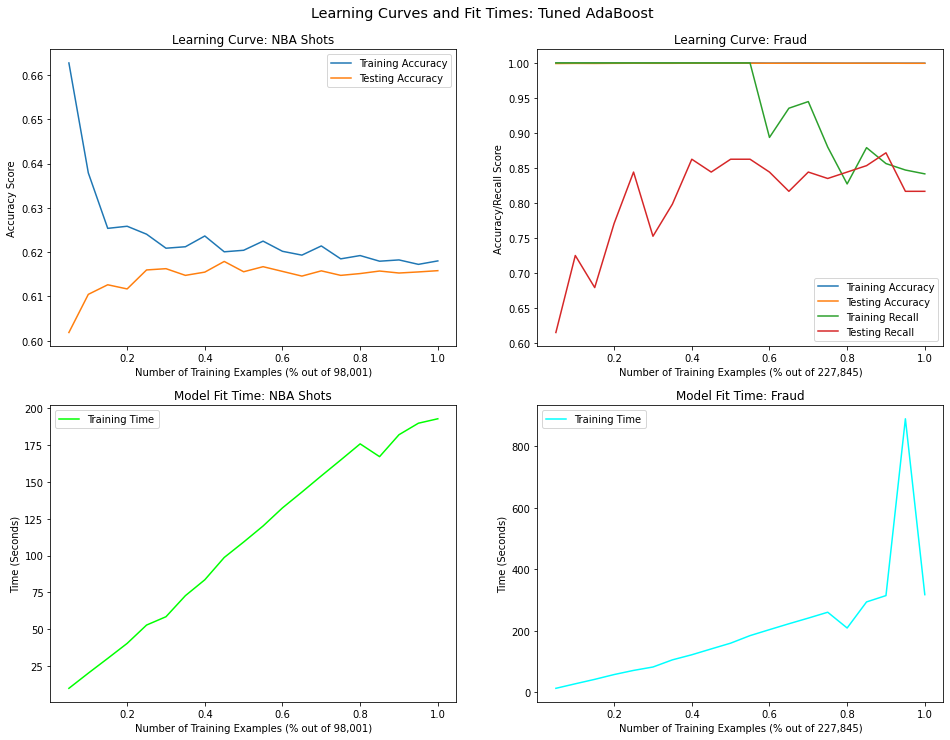

In [199]:
plot_metrics(ada_results, 'Tuned AdaBoost')

## K Nearest Neighbors

### Initial GridSearch

In [ ]:
knn_grid = {'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 50], 
            'weights': ['uniform', 'distance']}

knn_tuned1 = GridSearchCV(KNeighborsClassifier(), knn_grid, scoring='accuracy', cv=5, verbose=1)
knn_tuned2 = GridSearchCV(KNeighborsClassifier(), knn_grid, scoring='recall', cv=5, verbose=1)

In [ ]:
gridsearches(knn_tuned1, knn_tuned2, X1, y1, X2, y2)

In [18]:
knn_results_1 = pd.read_csv('knn_tuned1.csv')[['mean_fit_time', 'mean_score_time',
                                              'param_knn__n_neighbors', 'param_knn__weights', 
                                              'mean_test_score', 'rank_test_score']]
knn_results_2 = pd.read_csv('knn_tuned2.csv')[['mean_fit_time', 'mean_score_time',
                                              'param_knn__n_neighbors', 'param_knn__weights', 
                                              'mean_test_score', 'rank_test_score']]

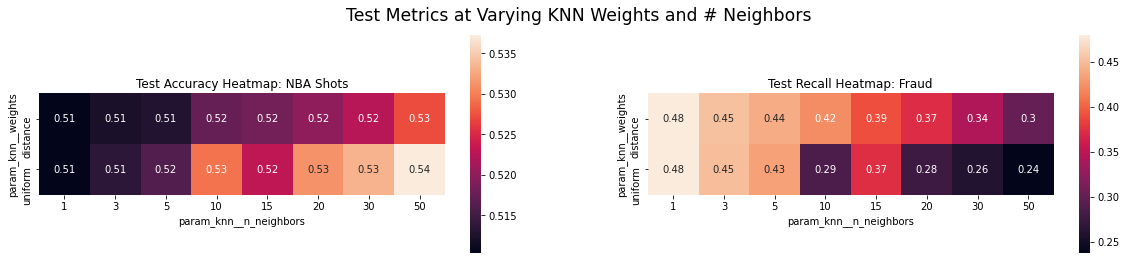

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))

sns.heatmap(knn_results_1.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_test_score'), square=True, annot=True, ax=ax0);

sns.heatmap(knn_results_2.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_test_score'), square=True, annot=True, ax=ax1);

ax0.set_title('Test Accuracy Heatmap: NBA Shots')
ax1.set_title('Test Recall Heatmap: Fraud')
plt.suptitle('Test Metrics at Varying KNN Weights and # Neighbors', fontsize='xx-large')
plt.show()

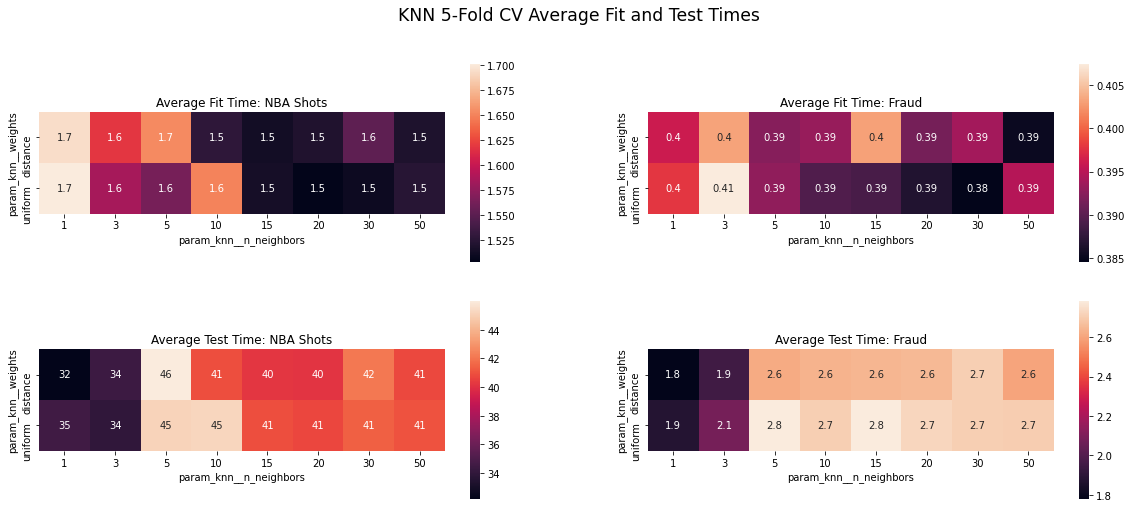

In [44]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 8))

sns.heatmap(knn_results_1.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_fit_time'), square=True, annot=True, ax=ax0);

sns.heatmap(knn_results_2.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_fit_time'), square=True, annot=True, ax=ax1);

sns.heatmap(knn_results_1.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_score_time'), square=True, annot=True, ax=ax2);

sns.heatmap(knn_results_2.pivot(index='param_knn__weights', columns='param_knn__n_neighbors', 
                   values='mean_score_time'), square=True, annot=True, ax=ax3);

ax0.set_title('Average Fit Time: NBA Shots')
ax1.set_title('Average Fit Time: Fraud')
ax2.set_title('Average Test Time: NBA Shots')
ax3.set_title('Average Test Time: Fraud')

plt.suptitle('KNN 5-Fold CV Average Fit and Test Times', fontsize='xx-large')
plt.show()

### Learning Curve

In [9]:
knn_pipe1_tuned = Pipeline([('ss', StandardScaler()), 
                          ('knn', KNeighborsClassifier(n_neighbors=50, weights='uniform'))])

knn_pipe2_tuned = Pipeline([('ss', StandardScaler()), 
                          ('knn', KNeighborsClassifier(n_neighbors=1, weights='uniform'))])

knn_results = sample_model(knn_pipe1_tuned, 
                           knn_pipe2_tuned, 
                           nba, cc)

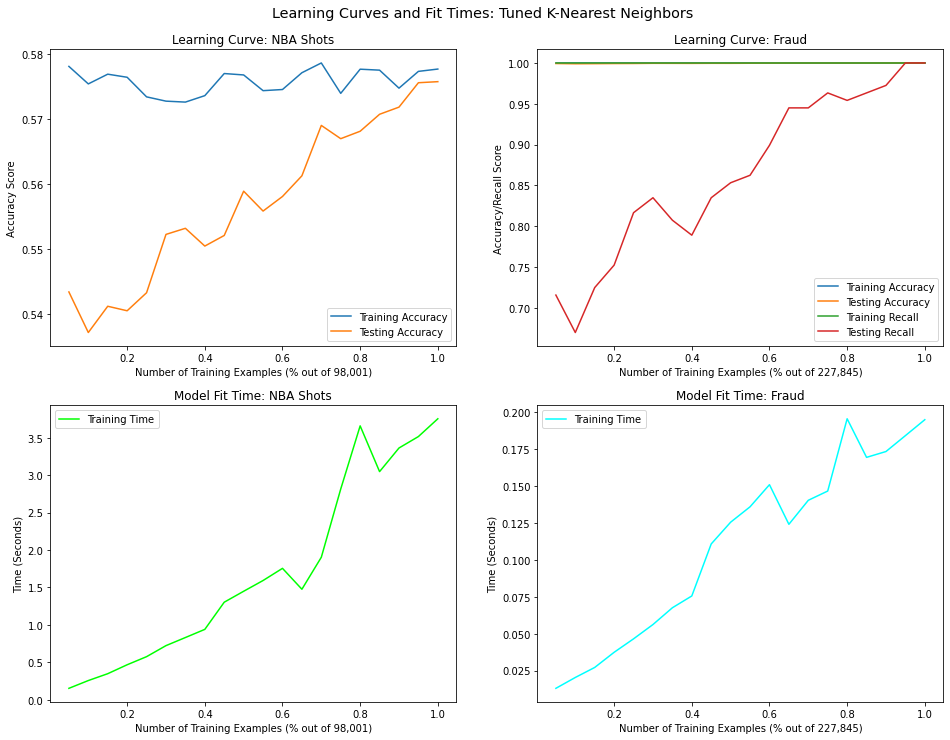

In [13]:
plot_metrics(knn_results, 'Tuned K-Nearest Neighbors')

## Support Vector Machine

### Initial GridSearch

In [205]:
svm_grid = {'svm__kernel': ['linear', 'rbf', 'sigmoid'], 
            'svm__C': [0.1, 0.5, 1, 10, 100]}

# Standard Scaler for distance-based learner

svm_pipe1 = Pipeline([('ss', StandardScaler()), 
                      ('svm', SVC())])

svm_pipe2 = Pipeline([('ss', StandardScaler()), 
                      ('svm', SVC())])

svm_tuned1 = GridSearchCV(svm_pipe1, svm_grid, scoring='accuracy', cv=5, verbose=2)
svm_tuned2 = GridSearchCV(svm_pipe2, svm_grid, scoring='recall', cv=5, verbose=2)

In [6]:
gridsearches(svm_tuned1, svm_tuned2, X1, y1, X2, y2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  52.6s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  42.4s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  39.6s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  43.4s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  40.5s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  37.1s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  37.5s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  37.0s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  36.7s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  39.2s
[CV] END ....................svm__C=0.1, svm__kernel=sigmoid; total time=  35.7s
[CV] END ....................svm__C=0.1, svm__ke

[CV] END ....................svm__C=0.5, svm__kernel=sigmoid; total time=   1.0s
[CV] END ....................svm__C=0.5, svm__kernel=sigmoid; total time=   1.0s
[CV] END ....................svm__C=0.5, svm__kernel=sigmoid; total time=   1.0s
[CV] END ....................svm__C=0.5, svm__kernel=sigmoid; total time=   1.0s
[CV] END ....................svm__C=0.5, svm__kernel=sigmoid; total time=   1.0s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  12.3s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=   9.7s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  13.1s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  11.2s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  16.2s
[CV] END ..........................svm__C=1, svm__kernel=rbf; total time=   1.7s
[CV] END ..........................svm__C=1, svm__kernel=rbf; total time=   1.8s
[CV] END ...................

(GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('ss', StandardScaler()),
                                        ('svm', SVC())]),
              param_grid={'svm__C': [0.1, 0.5, 1, 10, 100],
                          'svm__kernel': ['linear', 'rbf', 'sigmoid']},
              scoring='accuracy', verbose=2),
 GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('ss', StandardScaler()),
                                        ('svm', SVC())]),
              param_grid={'svm__C': [0.1, 0.5, 1, 10, 100],
                          'svm__kernel': ['linear', 'rbf', 'sigmoid']},
              scoring='recall', verbose=2))

In [14]:
svm_grid1 = pd.read_csv('svm_grid1.csv')
svm_grid2 = pd.read_csv('svm_grid2.csv')

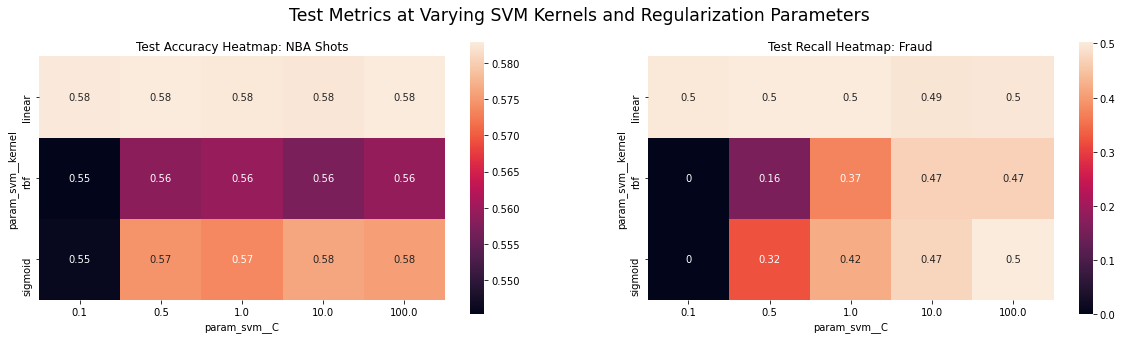

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(svm_grid1.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_test_score'), square=True, annot=True, ax=ax0);

sns.heatmap(svm_grid2.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_test_score'), square=True, annot=True, ax=ax1);

ax0.set_title('Test Accuracy Heatmap: NBA Shots')
ax1.set_title('Test Recall Heatmap: Fraud')
plt.suptitle('Test Metrics at Varying SVM Kernels and Regularization Parameters', fontsize='xx-large')
plt.show()

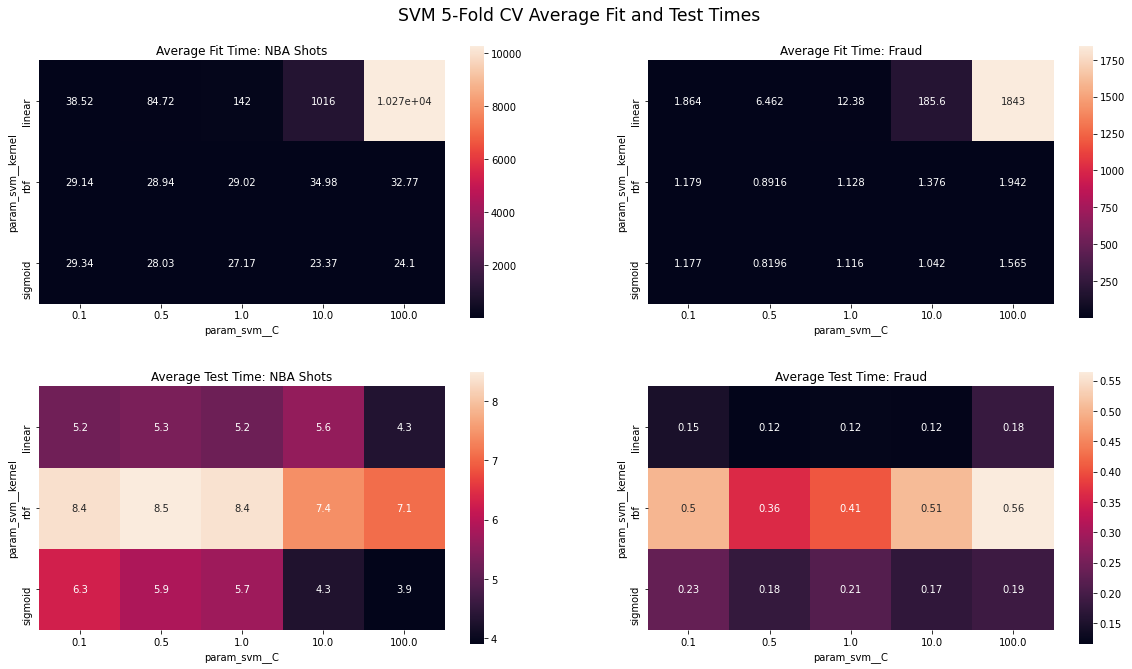

In [30]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 11))

sns.heatmap(svm_grid1.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_fit_time'), square=True, annot=True, ax=ax0, fmt='.4g');

sns.heatmap(svm_grid2.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_fit_time'), square=True, annot=True, ax=ax1, fmt='.4g');

sns.heatmap(svm_grid1.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_score_time'), square=True, annot=True, ax=ax2);

sns.heatmap(svm_grid2.pivot(index='param_svm__kernel', columns='param_svm__C', 
                   values='mean_score_time'), square=True, annot=True, ax=ax3);

ax0.set_title('Average Fit Time: NBA Shots')
ax1.set_title('Average Fit Time: Fraud')
ax2.set_title('Average Test Time: NBA Shots')
ax3.set_title('Average Test Time: Fraud')

plt.suptitle('SVM 5-Fold CV Average Fit and Test Times', fontsize='xx-large', y=0.93)
plt.show()

### Learning Curve

In [5]:
svm_pipe1_tuned = Pipeline([('ss', StandardScaler()), 
                          ('svm', SVC(kernel='linear', C=100))])

svm_pipe2_tuned = Pipeline([('ss', StandardScaler()), 
                          ('svm', SVC(kernel='linear', C=0.5))])

svm_results = sample_model(svm_pipe1_tuned, 
                           svm_pipe2_tuned, 
                           nba, cc)

svm_results.to_csv('svm_lr.csv')

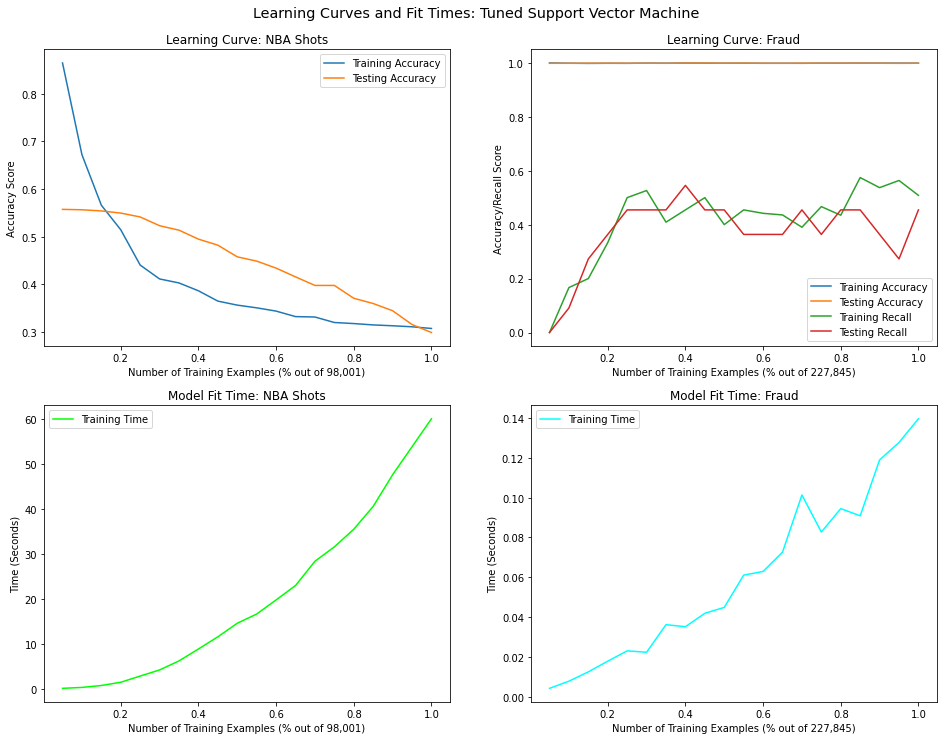

In [6]:
plot_metrics(svm_results, 'Tuned Support Vector Machine')

In [7]:
svm_results

,Count,Train Accuracy 1,Test Accuracy 1,Train Time 1,Train Accuracy 2,Test Accuracy 2,Train Recall 2,Test Recall 2,Train Time 2
0,0.05,0.864379,0.557143,0.084081,0.999298,0.998069,0.000000,0.000000,0.004303
1,0.10,0.671837,0.556327,0.285224,0.998244,0.998069,0.166667,0.090909,0.007881
2,0.15,0.565832,0.553878,0.712954,0.997659,0.998420,0.200000,0.272727,0.012561
3,0.20,0.514286,0.549388,1.435866,0.998069,0.998420,0.333333,0.363636,0.017925
4,0.25,0.440235,0.541224,2.815764,0.997893,0.998245,0.500000,0.454545,0.023100
5,0.30,0.411156,0.522857,4.176828,0.998596,0.998245,0.526316,0.454545,0.022409
6,0.35,0.402752,0.513469,6.188942,0.998395,0.998069,0.409091,0.454545,0.036240
7,0.40,0.386327,0.494694,8.839370,0.998859,0.998771,0.454545,0.545455,0.035218
8,0.45,0.364659,0.482041,11.547851,0.998439,0.998771,0.500000,0.454545,0.041948
9,0.50,0.356245,0.457551,14.573352,0.998315,0.998420,0.400000,0.454545,0.044910


## Neural Network

### Initial GridSearch

In [72]:
params = {'dropout': [0.1, 0.3, 0.5], 
          'nodes1': [100, 500, 1000], 
          'optimizer': ['adam', 'sgd'], 
          'activation1': ['relu', 'tanh'], 
          'activation2': ['relu', 'tanh']}

In [73]:
def dense_network1(x_train, y_train, x_test, y_test, params):

    # we build the model exactly like we would normally do it
    model = Sequential()

    # hidden layers
    model.add(Dense(params['nodes1'], input_dim=763, activation=params['activation1']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['nodes1'], activation=params['activation2']))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    out = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        batch_size=100,
                        epochs=10,
                        verbose=0)

    return out, model

def dense_network2(x_train, y_train, x_test, y_test, params):

    # we build the model exactly like we would normally do it
    model = Sequential()

    # hidden layers
    model.add(Dense(params['nodes1'], input_dim=29, activation=params['activation1']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['nodes1'], activation=params['activation2']))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'], metrics=[keras_metrics.recall()])
    
    out = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        batch_size=100,
                        epochs=10,
                        verbose=0)

    return out, model

In [ ]:
## to run gridsearch

results = talos.Scan(X_train.values, y_train.values, params=params, model=dense_network1, experiment_name='grid1')
results2 = talos.Scan(X_train2.values, y_train2.values, params=params, model=dense_network2, experiment_name='grid2')


In [66]:
nn1 = pd.read_csv('model_results/talos1.csv')
nn2 = pd.read_csv('model_results/talos2.csv')

In [68]:
nn1.sort_values('val_accuracy', ascending=False)

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation1,activation2,dropout,nodes1,optimizer
64,10,0.666401,0.600248,0.657988,0.616782,tanh,tanh,0.3,1000,adam
16,10,0.658394,0.612668,0.654863,0.616204,relu,relu,0.5,1000,adam
68,10,0.662635,0.610437,0.661999,0.616170,tanh,tanh,0.5,500,adam
60,10,0.656487,0.614781,0.654944,0.615693,tanh,tanh,0.3,100,adam
24,10,0.657005,0.615452,0.657164,0.615421,relu,tanh,0.3,100,adam
...,...,...,...,...,...,...,...,...,...,...
15,10,0.686684,0.547959,0.686376,0.547464,relu,relu,0.5,500,sgd
1,10,0.689448,0.544184,0.688361,0.542158,relu,relu,0.1,100,sgd
21,10,0.684443,0.563907,0.685146,0.535594,relu,tanh,0.1,500,sgd
51,10,0.683361,0.561079,0.684739,0.519914,tanh,relu,0.5,500,sgd


In [70]:
nn2.sort_values('val_loss', ascending=False)

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation1,activation2,dropout,nodes1,optimizer
17,10,0.013734,0.998896,0.022632,0.999342,relu,relu,0.5,1000,sgd
35,10,0.005726,0.999034,0.012061,0.999298,relu,tanh,0.5,1000,sgd
13,10,0.013982,0.998784,0.010880,0.999151,relu,relu,0.5,100,sgd
7,10,0.011182,0.998878,0.010852,0.999137,relu,relu,0.3,100,sgd
5,10,0.010525,0.998972,0.010602,0.999093,relu,relu,0.1,1000,sgd
15,10,0.014529,0.998922,0.009736,0.999122,relu,relu,0.5,500,sgd
11,10,0.012364,0.998928,0.009464,0.999137,relu,relu,0.3,1000,sgd
9,10,0.012755,0.998928,0.009315,0.999108,relu,relu,0.3,500,sgd
14,10,0.007779,0.999223,0.009155,0.999386,relu,relu,0.5,500,adam
1,10,0.011061,0.998890,0.008843,0.999137,relu,relu,0.1,100,sgd


### Epochs

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=21)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=21)

In [5]:
model = Sequential()

# hidden layers
model.add(Dense(1000, input_dim=763, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1000, activation='tanh'))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
            validation_data=(X_test, y_test),
            batch_size=100,
            epochs=10,
            verbose=1)

model.save('model.h5')
model.save_weights('model_weights.h5')

Epoch 1/10
981/981 [==============================] - 13s 13ms/step - loss: 0.6995 - accuracy: 0.5857 - val_loss: 0.7065 - val_accuracy: 0.5586
Epoch 2/10
981/981 [==============================] - 13s 14ms/step - loss: 0.6687 - accuracy: 0.5987 - val_loss: 0.7081 - val_accuracy: 0.5602
Epoch 3/10
981/981 [==============================] - 15s 15ms/step - loss: 0.6692 - accuracy: 0.6009 - val_loss: 0.7661 - val_accuracy: 0.4561
Epoch 4/10
981/981 [==============================] - 14s 14ms/step - loss: 0.6682 - accuracy: 0.6010 - val_loss: 0.7532 - val_accuracy: 0.4585
Epoch 5/10
981/981 [==============================] - 15s 15ms/step - loss: 0.6701 - accuracy: 0.5998 - val_loss: 0.6684 - val_accuracy: 0.6165
Epoch 6/10
981/981 [==============================] - 16s 16ms/step - loss: 0.6674 - accuracy: 0.6011 - val_loss: 0.7536 - val_accuracy: 0.4576
Epoch 7/10
981/981 [==============================] - 17s 17ms/step - loss: 0.6690 - accuracy: 0.6010 - val_loss: 0.7689 - val_accuracy:

In [6]:
model2 = Sequential()

# hidden layers
model2.add(Dense(1000, input_dim=29, activation='tanh'))
model2.add(Dropout(0.1))
model2.add(Dense(1000, activation='relu'))

# output layer
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_metrics.recall()])

history2 = model2.fit(X_train2, y_train2, 
            validation_data=(X_test2, y_test2),
            batch_size=100,
            epochs=10,
            verbose=1)

model2.save('model2.h5')
model2.save_weights('model_weights2.h5')

Epoch 1/10


/usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


2277/2279 [============================>.] - ETA: 0s - loss: 0.0080 - recall: 0.5228WARNING:tensorflow:`add_update` `inputs` kwarg has been deprecated. You no longer need to pass a value to `inputs` as it is being automatically inferred.


/usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


2279/2279 [==============================] - 27s 12ms/step - loss: 0.0080 - recall: 0.5229 - val_loss: 0.0044 - val_recall: 0.6209
Epoch 2/10
2279/2279 [==============================] - 26s 12ms/step - loss: 0.0043 - recall: 0.6452 - val_loss: 0.0061 - val_recall: 0.6596
Epoch 3/10
2279/2279 [==============================] - 28s 12ms/step - loss: 0.0046 - recall: 0.6533 - val_loss: 0.0044 - val_recall: 0.6582
Epoch 4/10
2279/2279 [==============================] - 27s 12ms/step - loss: 0.0044 - recall: 0.6591 - val_loss: 0.0049 - val_recall: 0.6610
Epoch 5/10
2279/2279 [==============================] - 26s 12ms/step - loss: 0.0046 - recall: 0.6600 - val_loss: 0.0041 - val_recall: 0.6629
Epoch 6/10
2279/2279 [==============================] - 28s 12ms/step - loss: 0.0041 - recall: 0.6655 - val_loss: 0.0099 - val_recall: 0.6604
Epoch 7/10
2279/2279 [==============================] - 28s 12ms/step - loss: 0.0045 - recall: 0.6566 - val_loss: 0.0040 - val_recall: 0.6602
Epoch 8/10
2279/2

<ipython-input-8-3d0253cf102a>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


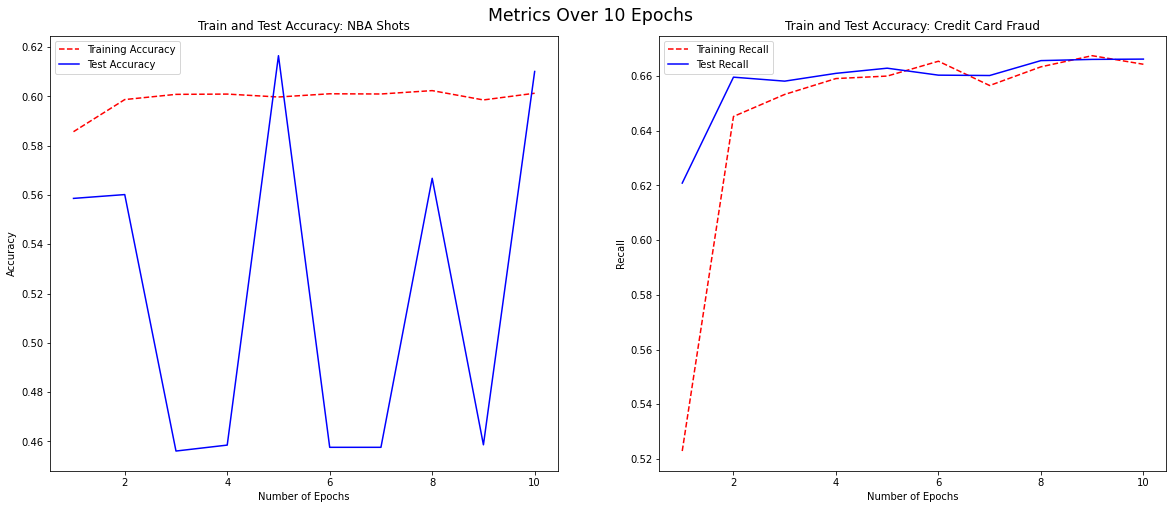

In [8]:
# Get training and test loss/accuracy histories
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

training_acc2 = history2.history['recall']
test_acc2 = history2.history['val_recall']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Visualize accuracy  history
ax1.plot(epoch_count, training_acc, 'r--')
ax1.plot(epoch_count, test_acc, 'b-')
ax1.legend(['Training Accuracy', 'Test Accuracy'])
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train and Test Accuracy: NBA Shots')

ax2.plot(epoch_count, training_acc2, 'r--')
ax2.plot(epoch_count, test_acc2, 'b-')
ax2.legend(['Training Recall', 'Test Recall'])
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Recall')
ax2.set_title('Train and Test Accuracy: Credit Card Fraud')

fig.suptitle('Metrics Over 10 Epochs', fontsize='xx-large', y=0.93)

fig.show();

### Learning Curve

In [10]:
nn_results = sample_nnmodel(model, model2, nba, cc)

  9/445 [..............................] - ETA: 3s - loss: 3.3939e-04 - recall: 0.6663  

/usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


8901/8901 [==============================] - 54s 6ms/step - loss: 0.0066 - recall: 0.6844


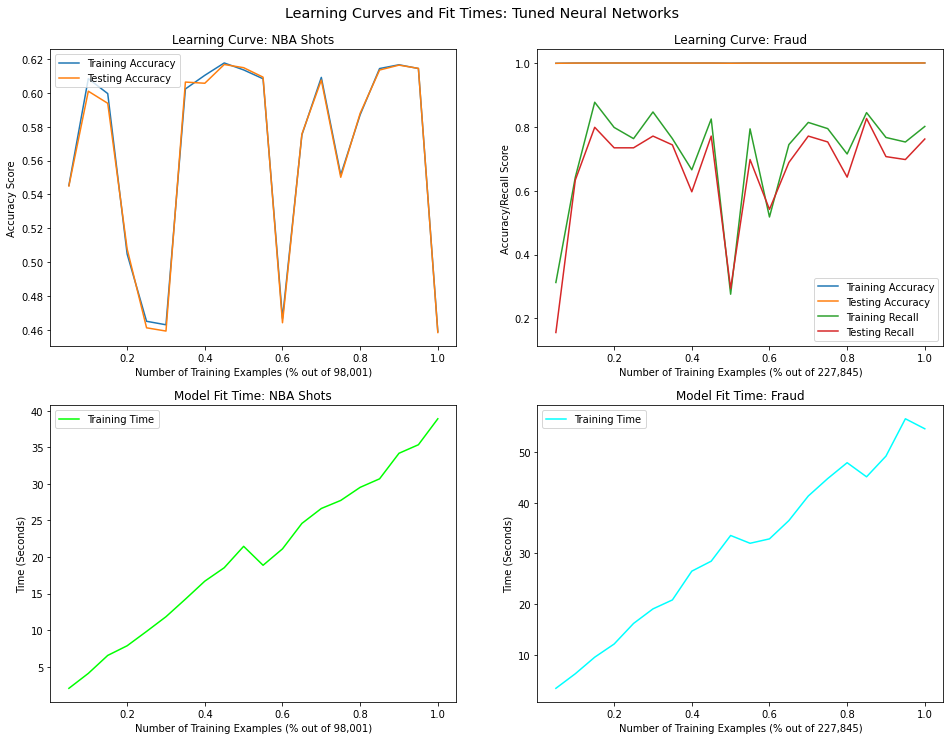

In [12]:
plot_metrics(nn_results, "Tuned Neural Networks")

In [13]:
nn_results

,Count,Train Accuracy 1,Test Accuracy 1,Train Time 1,Train Accuracy 2,Test Accuracy 2,Train Recall 2,Test Recall 2,Train Time 2
0,0.05,0.545306,0.544957,2.041494,0.998455,0.998385,0.312500,0.155963,3.351946
1,0.10,0.608327,0.600914,4.083189,0.999228,0.999140,0.641509,0.633028,6.227240
2,0.15,0.599510,0.593772,6.540819,0.999462,0.999192,0.876543,0.798165,9.494465
3,0.20,0.504776,0.507775,7.861484,0.999403,0.999333,0.797753,0.733945,12.092122
4,0.25,0.465095,0.461246,9.823352,0.999368,0.999315,0.762712,0.733945,16.155177
5,0.30,0.463035,0.459328,11.833550,0.999450,0.999333,0.846154,0.770642,19.027145
6,0.35,0.602248,0.606302,14.234853,0.999358,0.999333,0.762712,0.743119,20.793283
7,0.40,0.610294,0.605608,16.696827,0.999192,0.999122,0.665158,0.596330,26.474122
8,0.45,0.617585,0.616669,18.531251,0.999321,0.999245,0.824074,0.770642,28.444030
9,0.50,0.613476,0.614791,21.458040,0.998799,0.998613,0.275862,0.293578,33.514404
